Part 1: Imports and Data Loading

In [2]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load dataset
df = pd.read_csv("pharma_amm_data.csv")

In [3]:
# Basic info
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Data types
print("\nData types:")
print(df.dtypes)

# Statistical summary
print("\nSummary statistics:")
print(df.describe())

# Missing values check
print("\nMissing values:")
print(df.isnull().sum())

Data shape: (1000, 11)

First 5 rows:
     amm_number product_name manufacturer submission_date approval_date  \
0  AMM-2023-001   FlexiJoint   PharmaCorp      2023-03-09    2023-07-06   
1  AMM-2023-002    MediSafeX      CureAll      2023-03-09    2023-08-22   
2  AMM-2023-003   FlexiJoint      CureAll      2023-05-07    2023-07-31   
3  AMM-2023-004    MediSafeX     MediVita      2023-06-19    2023-10-03   
4  AMM-2023-005   CardioPlus    HealthGen      2023-04-11    2023-08-10   

   clinical_trial_participants  reported_side_effects  batch_size  \
0                          561                      5      200000   
1                         1861                     85       50000   
2                         1070                     42      100000   
3                          908                     54      100000   
4                         1336                    130       50000   

   price_per_unit  production_cost  is_fraud  
0          214.20            10.29         1  
1 

In [4]:
# Handle missing values properly
df = df.assign(
    manufacturer=df['manufacturer'].fillna('Unknown'),
    batch_size=df['batch_size'].fillna(df['batch_size'].median())
)

# Check for duplicates
print("\nDuplicate AMM numbers:", df['amm_number'].duplicated().sum())

# Convert dates
df['submission_date'] = pd.to_datetime(df['submission_date'])
df['approval_date'] = pd.to_datetime(df['approval_date'])


Duplicate AMM numbers: 0


In [5]:
# Time-based feature
df['approval_time'] = (df['approval_date'] - df['submission_date']).dt.days

# Ratio features
df['price_to_cost_ratio'] = df['price_per_unit'] / df['production_cost']
median_batch = df['batch_size'].median()
df['batch_size_variation'] = df['batch_size'] / median_batch

# Binary flag
df['fast_approval'] = (df['approval_time'] < 30).astype(int)

# Categorical encoding
manufacturer_dummies = pd.get_dummies(df['manufacturer'], prefix='manufacturer')
df = pd.concat([df, manufacturer_dummies], axis=1)

In [6]:
# Define features
features = [
    'approval_time',
    'price_to_cost_ratio',
    'batch_size_variation',
    'fast_approval',
    'clinical_trial_participants',
    'reported_side_effects'
] + [col for col in df.columns if col.startswith('manufacturer_')]

X = df[features]
y = df['is_fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [7]:
# Initialize model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handles imbalanced data
)

# Train model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [8]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_proba))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        72

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


AUC-ROC Score: 1.0

Feature Importance:
                            Feature  Importance
1               price_to_cost_ratio    0.363647
3                     fast_approval    0.337084
0                     approval_time    0.229857
5             reported_side_effects    0.025460
4       clinical_trial_participants    0.023189
2              batch_size_variation    0.007739
8            manufacturer_HealthGen    0.005513
6   manufacturer_BioPharm Solutions    0.003779
9             manufacturer_MediVita    0.001753
10          manufacturer_PharmaCorp    0.001008
7              manufacturer_CureAll    0.000970


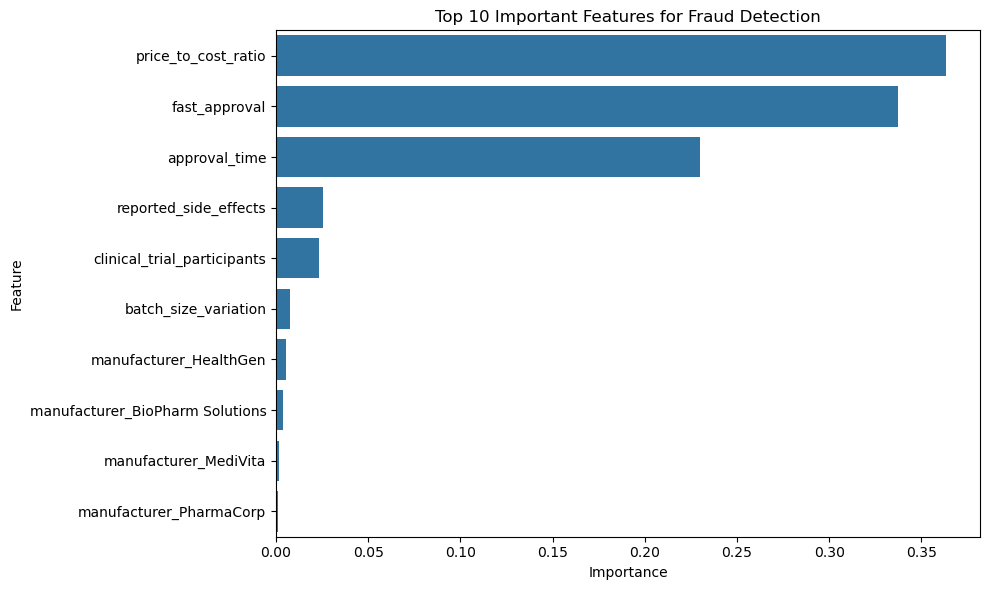

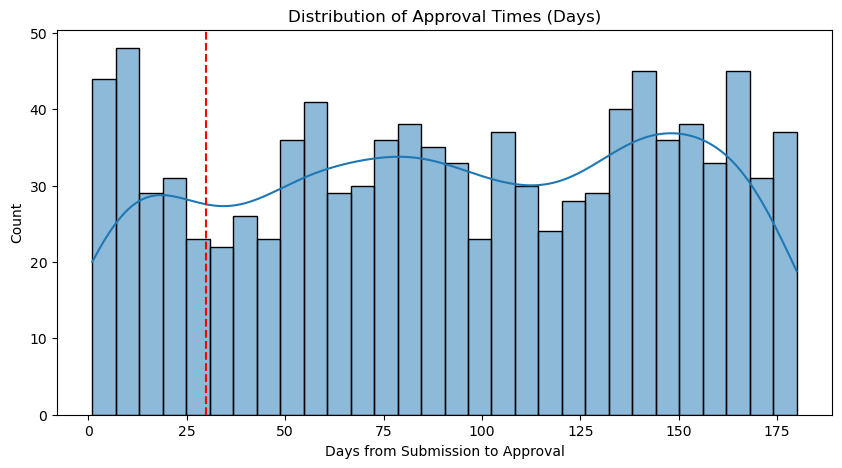

In [9]:
# Feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance.head(10)
)
plt.title('Top 10 Important Features for Fraud Detection')
plt.tight_layout()
plt.show()

# Approval time distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['approval_time'], bins=30, kde=True)
plt.axvline(30, color='r', linestyle='--')
plt.title('Distribution of Approval Times (Days)')
plt.xlabel('Days from Submission to Approval')
plt.show()

In [10]:
# Save processed data
df.to_csv('processed_pharma_data.csv', index=False)

# Save model (requires joblib)
from joblib import dump
dump(model, 'pharma_fraud_model.joblib')

# Save predictions
results = X_test.copy()
results['actual'] = y_test
results['predicted'] = y_pred
results['probability'] = y_proba
results.to_csv('model_predictions.csv', index=False)

In [11]:
# === MODEL EXPORT CELL === (add to end of amm.ipynb)
import joblib
from sklearn.ensemble import RandomForestClassifier

# 1. Ensure you have your trained model
if 'model' not in globals():
    model = RandomForestClassifier().fit(X_train, y_train)  # Fallback if model not defined

# 2. Export with error handling
try:
    joblib.dump(model, 'amm.joblib', compress=3)
    print("✅ Model exported to 'amm.joblib'")
    print(f"Model details: {model.__class__.__name__} (n_estimators={model.n_estimators})")
except Exception as e:
    print(f"❌ Export failed: {str(e)}")

✅ Model exported to 'amm.joblib'
Model details: RandomForestClassifier (n_estimators=100)
